# Q4

In [1]:
import gym
env = gym.make("Taxi-v3").env
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


Random initial state

In [3]:
state = env.encode(1, 2, 3, 4) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 156
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
env.P[156]

{0: [(1.0, 256, -1, False)],
 1: [(1.0, 56, -1, False)],
 2: [(1.0, 176, -1, False)],
 3: [(1.0, 156, -1, False)],
 4: [(1.0, 156, -10, False)],
 5: [(1.0, 156, -10, False)]}

In [5]:
env.s = 156  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 2443
Penalties incurred: 782


In [6]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [7]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1 
gamma = 0.9 #discount factor
epsilon = 0.2#trade off between explore and exploit

all_rewards=[]
avg100_returns=[]


for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    episode_reward=0
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
        

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        episode_reward+=old_value
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    all_rewards.append(episode_reward)
    avg100=sum(all_rewards[max(0,i-100)::])/min(i,100)
    avg100_returns.append(avg100)
    if i % 100 == 0:

        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")
"""Plotting Q-learning Returns"""

Episode: 100000
Training finished.



'Plotting Q-learning Returns'

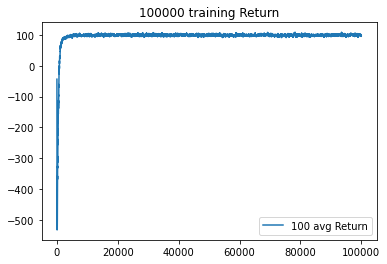

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(100000),avg100_returns,label='100 avg Return')
plt.title('100000 training Return')
plt.legend()
plt.show()
print()

In [9]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 1000

for i in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    episode_return=0
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
        episode_return+=reward

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


Results after 1000 episodes:
Average timesteps per episode: 12.931
Average penalties per episode: 0.0


# Q5

In [10]:
import numpy as np
import pandas as pd
# BeautifulSoup is used to remove html tags from the text
from bs4 import BeautifulSoup 
import re # For regular expressions
from nltk.corpus import stopwords
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\65873\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
train = pd.read_csv("C:/Users/65873/Downloads/CS601 Intro to AI/word2vec/word2vec/input/200Reviews.csv")


In [12]:
train

,Unnamed: 0,id,sentiment,review
0,0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...,...
195,195,"""8807_9""",1,"""This is a collection of documentaries that la..."
196,196,"""12148_10""",1,"""This movie has a lot of comedy, not dark and ..."
197,197,"""10771_2""",0,"""Have not watched kids films for some years, s..."
198,198,"""6766_3""",0,"""You probably heard this phrase when it come t..."


In [13]:
def review_wordlist(review, remove_stopwords=True):
    # 1. Removing html tags
    review_text = BeautifulSoup(review).get_text()
    # 2. Removing non-letter.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    # 3. Converting to lower case and splitting
    words = review_text.lower().split()
    # 4. Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    
    return(words)

In [14]:
def review_sentences(review, tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence))

    # This returns the list of lists
    return sentences

In [15]:
sentences = []
print(len(train["review"]))
count=0
print("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_sentences(review, tokenizer)
    count+=1
    if count%100 == 0:
        print(count)
    
print("Finished parsing sentences")

200
Parsing sentences from training set
100
200
Finished parsing sentences


In [16]:
len(sentences)

1996

# with gensim word_to_vec

In [17]:
# Creating the model and setting values for the various parameters
num_features = 75  # Word vector dimensionality
min_word_count = 0 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 7      # Context window size
downsampling = 0 #1e-3 # (0.001) Downsample setting for frequent words


In [18]:
# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          vector_size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

Training model....


In [19]:
# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "75features_7context"
model_path = F"C:/Users/65873/Downloads/CS601 Intro to AI/word2vec/word2vec/{model_name}"
model.save(model_path)
print("model saved")


model saved


<ipython-input-19-102b9ea377d7>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [20]:
model = word2vec.Word2Vec.load(model_path)
model.wv.doesnt_match("man woman dog child kitchen".split()) 

'kitchen'

the gensim word to vec is bad 

# count based vector, SVD

In [21]:
#getting a co-occurence matrix 

In [22]:
print (sentences[0])

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker']


get a vocabulary from the training data, note that punctuation mark such as '.' is removed, does it harm the accuracy?

In [23]:
voc_list = set()
for sentence in sentences:
    words = [word for word in sentence if word not in voc_list ]
    voc_list = voc_list.union(set(words))
voc_list=list(voc_list)

In [24]:
len(voc_list)

7004

In [25]:
voc_dict=dict()
for w in voc_list:
    voc_dict[w]=voc_list.index(w)

In [26]:
voc_dict

{'seductive': 0,
 'receptive': 1,
 'beautifully': 2,
 'scares': 3,
 'square': 4,
 'arranged': 5,
 'pons': 6,
 'helen': 7,
 'thuggees': 8,
 'connor': 9,
 'stumbled': 10,
 'signal': 11,
 'erased': 12,
 'thanksgiving': 13,
 'visions': 14,
 'sarcastic': 15,
 'towers': 16,
 'centres': 17,
 'mission': 18,
 'gilligan': 19,
 'proudly': 20,
 'elegiac': 21,
 'located': 22,
 'unsaved': 23,
 'fallwell': 24,
 'inclusion': 25,
 'eastwood': 26,
 'martial': 27,
 'rehashed': 28,
 'speech': 29,
 'release': 30,
 'willem': 31,
 'thin': 32,
 'donating': 33,
 'dying': 34,
 'cow': 35,
 'watchable': 36,
 'hugely': 37,
 'respecting': 38,
 'origins': 39,
 'sequences': 40,
 'holiday': 41,
 'walken': 42,
 'rise': 43,
 'carlito': 44,
 'eternal': 45,
 'technical': 46,
 'instructor': 47,
 'fulfill': 48,
 'via': 49,
 'dialogs': 50,
 'awfully': 51,
 'survived': 52,
 'wells': 53,
 'holly': 54,
 'portrayals': 55,
 'thrown': 56,
 'checking': 57,
 'diversions': 58,
 'crutches': 59,
 'mj': 60,
 'overlong': 61,
 'looking': 

initialize a 7004*7004 matrix 

In [27]:
cooc=np.zeros((7004,7004))

In [28]:
def update_cooc(cooc, sentences,context):
    for sentence in sentences:
        for i in range(len(sentence)):
            neighbor=sentence[max(0,(i-context)):min(len(sentence),(i+context+1))]
            for w in neighbor:
                cooc[voc_dict[sentence[i]],voc_dict[w]]+=1
            cooc[voc_dict[sentence[i]],voc_dict[sentence[i]]]-=1
    return cooc
                
            
            

In [29]:
cooc=update_cooc(cooc,sentences,7)

In [30]:
cooc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

svd

In [31]:
# Singular-value decomposition
from numpy import array
from scipy.linalg import svd
from numpy import diag
from numpy import dot
from numpy import zeros
# define a matrix
A = cooc
# SVD
U, s, VT = svd(A)
print(U)
print(s)
print(VT)

[[-3.81439747e-05  1.26076867e-04 -1.27521732e-05 ... -3.81465523e-15
  -4.28954160e-16  2.47433993e-15]
 [-1.94169808e-03  7.43795993e-03  4.62597318e-03 ...  1.92144725e-14
   4.21885006e-15 -1.32621192e-14]
 [-2.54852245e-03 -8.82052354e-03  5.39671581e-03 ... -1.57954680e-15
  -3.16325396e-16  1.22557382e-15]
 ...
 [-3.70932953e-03 -8.37976769e-03  3.91756843e-03 ...  2.67066887e-14
   3.37977821e-15 -1.47446724e-14]
 [-7.18115284e-04 -6.00269836e-03 -6.85078099e-04 ... -1.79046872e-15
  -3.08684784e-16 -1.02043260e-15]
 [-1.39417602e-03 -5.85982553e-03  7.26938515e-03 ... -7.62969946e-16
  -1.06232728e-16  3.46236897e-16]]
[2.82169796e+02 8.21555447e+01 7.28328854e+01 ... 3.12845852e-16
 1.64436143e-16 6.21733855e-17]
[[-3.81439747e-05 -1.94169808e-03 -2.54852245e-03 ... -3.70932953e-03
  -7.18115284e-04 -1.39417602e-03]
 [ 1.26076867e-04  7.43795993e-03 -8.82052354e-03 ... -8.37976769e-03
  -6.00269836e-03 -5.85982553e-03]
 [ 1.27521732e-05 -4.62597318e-03 -5.39671581e-03 ... -3.

In [32]:
print(U.shape)
print(s.shape)
print(VT.shape)

(7004, 7004)
(7004,)
(7004, 7004)


In [33]:
# Reconstruct SVD
# create m x n Sigma matrix
Sigma = np.zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[0], :A.shape[0]] = np.diag(s)
# select
n_elements = 75
Sigma = Sigma[:, :75]
VT = VT[:n_elements, :]
# reconstruct
#B = U.dot(Sigma.dot(VT))
#print(B)
# transform
T = U.dot(Sigma)
print(T)
# or 
#T = A.dot(VT.T)
#print(T)

[[-1.07630776e-02  1.03579137e-02 -9.28777569e-04 ...  3.52666002e-04
  -5.28906988e-03  1.32462167e-02]
 [-5.47888550e-01  6.11069650e-01  3.36922974e-01 ... -1.64077286e-02
   7.22666492e-02  6.13584069e-02]
 [-7.19116060e-01 -7.24654916e-01  3.93058384e-01 ...  2.03758066e-01
  -1.00286379e-01  9.73717564e-02]
 ...
 [-1.04666076e+00 -6.88444380e-01  2.85327812e-01 ... -6.56222506e-03
  -3.54118066e-01  4.28247411e-01]
 [-2.02630443e-01 -4.93154954e-01 -4.98962147e-02 ...  7.04524001e-02
  -8.13727844e-02 -6.34003008e-02]
 [-3.93394363e-01 -4.81417158e-01  5.29450295e-01 ... -2.54554830e-02
   4.61570149e-03 -4.05645888e-02]]


In [34]:
print(T.shape)

(7004, 75)


get embedding for each word

In [35]:
word_vec2=dict()
for w in voc_dict.keys():
    word_vec2[w]=T[voc_dict[w]]  

In [45]:
print(word_vec2['computer'])

[-0.57434078 -0.10432003 -0.36954354 -0.20037519  0.08331285  0.05591366
  0.1474228  -0.15942787 -0.38774035  0.44994112 -0.09577395 -0.22301813
  0.11305235 -0.01500887  0.07000466  0.07585523 -0.18269257  0.0349237
  0.13689053  0.09105688  0.2758674   0.00925402  0.16893177  0.26046137
  0.06695559 -0.08840592  0.05019017  0.17356263 -0.0851495  -0.42988167
  0.29338702  0.16286581  0.38536457  0.34500487 -0.06509963  0.11195646
  0.01250821  0.1328769  -0.1992964   0.22920337 -0.10494248 -0.24682113
 -0.28802169 -0.03266742 -0.43120884  0.312442   -0.19025979 -0.48390726
 -0.17974172  0.51919798  0.21341294  0.25989283 -0.27242687  0.39310437
 -0.30189733 -0.10962226  0.14150346 -0.02741079 -0.12528311 -0.23733292
  0.2154836  -0.28129668 -0.23667791  0.20609815  0.24077912 -0.3040738
  0.13413621 -0.15468685 -0.06850732  0.27106467  0.26232749  0.31830456
  0.18899383 -0.45116019  0.20023455]


In [37]:
def similarity(w1,w2):
    return((word_vec2[w1].dot(word_vec2[w2])))/((np.linalg.norm(word_vec2[w1]))*(np.linalg.norm(word_vec2[w2])))

In [38]:
similarity('riled','jung')

-0.03467304026205625

In [39]:
def most_similar(w1):
    sim=dict()
    for w in voc_dict:
        if w1!=w:
            sim[w]=similarity(w1,w)    
    sorted_sim={k: v for k, v in sorted(sim.items(), reverse=True, key=lambda item: item[1])[:10]}
    return (sorted_sim)

# compare count-based embedding with predictive embedding

In [40]:
most_similar('horror')

{'worth': 0.7231916055065782,
 'anthology': 0.7213735089102122,
 'expect': 0.7163220879642826,
 'third': 0.7061636143324531,
 'italian': 0.6928859256920792,
 'one': 0.6892852135261253,
 'panacea': 0.6880147937690477,
 'helicopter': 0.6828871820391096,
 'silly': 0.6816772479281851,
 'licensing': 0.664208011449411}

In [41]:
model.wv.most_similar('horror')

[('like', 0.8317795991897583),
 ('people', 0.813900351524353),
 ('really', 0.8131250143051147),
 ('film', 0.8115131855010986),
 ('one', 0.8099021315574646),
 ('movie', 0.8088856935501099),
 ('make', 0.805974543094635),
 ('first', 0.8012202382087708),
 ('well', 0.7997719645500183),
 ('get', 0.7979276180267334)]

In [83]:
most_similar('movie')

{'moments': 0.7392321364155104,
 'really': 0.7209495614653431,
 'one': 0.7194125924994128,
 'film': 0.7022850593175857,
 'look': 0.6950885123740992,
 'good': 0.6898368234383659,
 'thing': 0.6879649110425916,
 'potential': 0.6797390355399279,
 'like': 0.678796080839742,
 'saw': 0.6780958079277362}

In [84]:
model.wv.most_similar('movie')

[('film', 0.9937667846679688),
 ('one', 0.9915928840637207),
 ('like', 0.983267068862915),
 ('even', 0.9728509187698364),
 ('good', 0.972465991973877),
 ('people', 0.9666380286216736),
 ('make', 0.9631043672561646),
 ('story', 0.9621517658233643),
 ('get', 0.9595617651939392),
 ('bad', 0.9586759805679321)]